In [3]:
import requests as r
response = r.get("https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/spa.word.test.gold.tsv")



In [6]:
import pandas as pd

LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}
CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

In [7]:
def get_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo basados en el idioma y el track

    Parameters:
    ----------
    lang : str
        Idioma para el cual se generarán los nombres de archivo.
    track : str, optional
        Track del shared task de donde vienen los datos (por defecto es "word").

    Returns:
    -------
    list[str]
        Una lista de nombres de archivo generados para el idioma y el track especificados.
    """
    base = f"{lang}.{track}"
    return [
        f"{base}.dev.tsv",
        #f"{base}.train.tsv",
        f"{base}.test.gold.tsv"
    ]

In [8]:
def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv desde una URL base.

    Parameters:
    ----------
    files : list
        Lista de nombres de archivos (sin extensión) que se descargarán
        y concatenarán.

    Returns:
    -------
    list
        Una lista que contiene los contenidos descargados y concatenados
        de los archivos tsv.
    """
    result = []
    for file in files:
        print(f"Downloading {file}.tsv")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}")
        response_list = response.text.split("\n")
        result.extend(response_list[:-1]) # Last element is empty string ''
    return result

In [9]:
def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame

    Parameters:
    ----------
    corpus_list : list
        Lista de líneas del corpus a convertir en DataFrame.
    lang : str
        Idioma al que pertenecen los datos del corpus.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del corpus procesados.
    """
    data = []
    for row in corpus_list:
        try:
            word, morphs, category = row.split("\t")
        except ValueError:
            # Caso donde no hay categoria
            word, morphs = row.split("\t")
            category = "N/A"
        morphs = morphs.split()
        data.append({"words": word, "morphs": morphs, "category": category, "lang": lang})
    df = pd.DataFrame(data)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morphs_count"] = df["morphs"].apply(lambda x: len(x))
    return df


In [10]:
files = get_files("spa")
raw_data = get_raw_corpus(files)
df = raw_corpus_to_dataframe(raw_data, lang="spa")

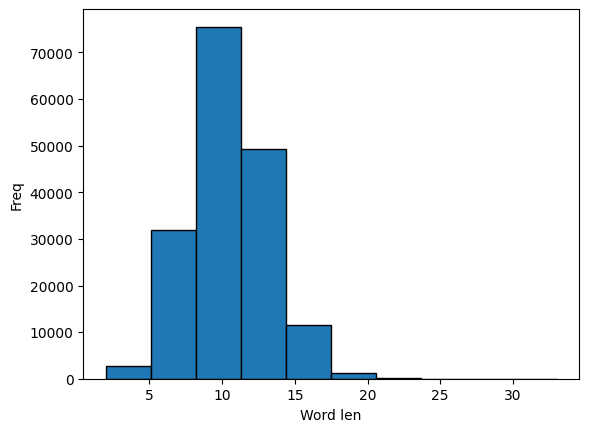

In [11]:
import matplotlib.pyplot as plt
plt.hist(df["word_len"], bins=10, edgecolor="black")
plt.xlabel("Word len")
plt.ylabel("Freq")
plt.show()

In [12]:
def plot_histogram(df, kind, lang):
    """Genera un histograma de frecuencia para una columna específica
    en un DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame que contiene los datos para generar el histograma.
    kind : str
        Nombre de la columna para la cual se generará el histograma.
    lang : str
        Idioma asociado a los datos.

    Returns:
    -------
    None
        Esta función muestra el histograma usando matplotlib.
    """
    counts = df[kind].value_counts().head(30)
    plt.bar(counts.index, counts.values)
    plt.xlabel(kind.upper())
    plt.ylabel('Frequency')
    plt.title(f'{kind} Frequency Graph for {lang}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

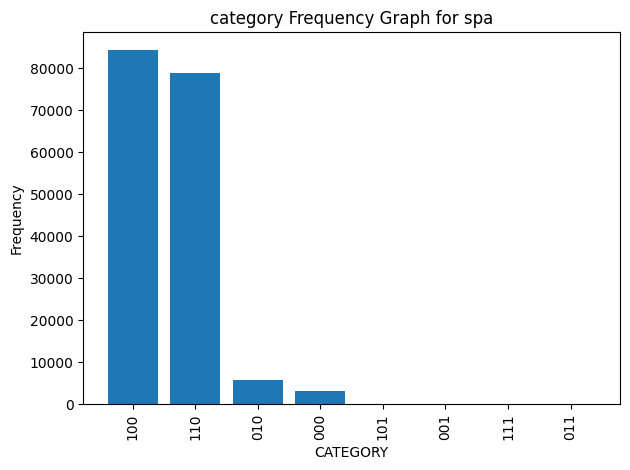

In [13]:
plot_histogram(df, "category", "spa")

In [14]:
def get_corpora() -> pd.DataFrame:
    """Obtiene y combina datos de corpus de diferentes idiomas en un DataFrame
    obteniendo corpora multilingüe

    Returns:
    -------
    pd.DataFrame
        Un DataFrame que contiene los datos de corpus combinados de varios idiomas.
    """
    corpora = pd.DataFrame()
    for lang in LANGS:
        files = get_files(lang)
        raw_data = get_raw_corpus(files)
        dataframe = raw_corpus_to_dataframe(raw_data, lang)
        corpora = dataframe if corpora.empty else pd.concat([corpora, dataframe], ignore_index=True)
    return corpora

corpora = get_corpora()

In [15]:
for lang in LANGS:
    df = corpora[corpora["lang"] == lang]
    print(f"Basic stats for {LANGS[lang]}")
    print("Total words:", len(df["words"].unique()))
    print("Mean morphs: ", df["morphs_count"].mean())
    most_common_cat = df["category"].mode()[0]
    print("Most common category:", most_common_cat, CATEGORIES.get(most_common_cat, ""))
    print("="*30)


Basic stats for Czech
Total words: 7790
Mean morphs:  3.59075
Most common category: N/A 
Basic stats for English
Total words: 115126
Mean morphs:  2.353230373677536
Most common category: 010 Derivation
Basic stats for French
Total words: 63173
Mean morphs:  2.6686400835800104
Most common category: 110 Inflection, Derivation
Basic stats for Hungarian
Total words: 188074
Mean morphs:  3.2302816976296564
Most common category: 100 Inflection
Basic stats for Spanish
Total words: 172173
Mean morphs:  3.236227515347935
Most common category: 100 Inflection
Basic stats for Italian
Total words: 92304
Mean morphs:  2.682657306292252
Most common category: 110 Inflection, Derivation
Basic stats for Latin
Total words: 176467
Mean morphs:  2.4890036097400645
Most common category: N/A 
Basic stats for Russian
Total words: 156846
Mean morphs:  3.851561404179896
Most common category: 110 Inflection, Derivation


In [16]:
# Lista de lenguas con sus colores
LANG_COLORS = {
    'ces': 'blue',
    'eng': 'green',
    'fra': 'red',
    'hun': 'purple',
    'spa': 'orange',
    'ita': 'brown',
    'lat': 'pink',
    'rus': 'gray'
}

def plot_multi_lang(column: str) -> None:
    """Genera un conjunto de subplots para mostrar la distribución
    de los datos de cierta columna en un dataframe para idiomas disponibles.

    Parameters:
    ----------
    column : str
        Nombre de la columna cuya distribución se va a graficar.

    Returns:
    -------
    None
        Esta función muestra los subplots usando matplotlib.
    """
    # Creando plots
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
    fig.suptitle(f"{column.upper()} Distribution by Language", fontsize=16)
    # Iteramos sobre las lenguas y sus colores para plotearlos
    for i, (lang, color) in enumerate(LANG_COLORS.items()):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        corpus = corpora[corpora['lang'] == lang]
        ax.hist(corpus[column], bins=10, edgecolor='black', alpha=0.7, color=color)
        ax.set_title(LANGS[lang])
        ax.set_xlabel(f"{column}")
        ax.set_ylabel("Frequency")

    # Ajustando el layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    # Mostramos el plot
    plt.show()

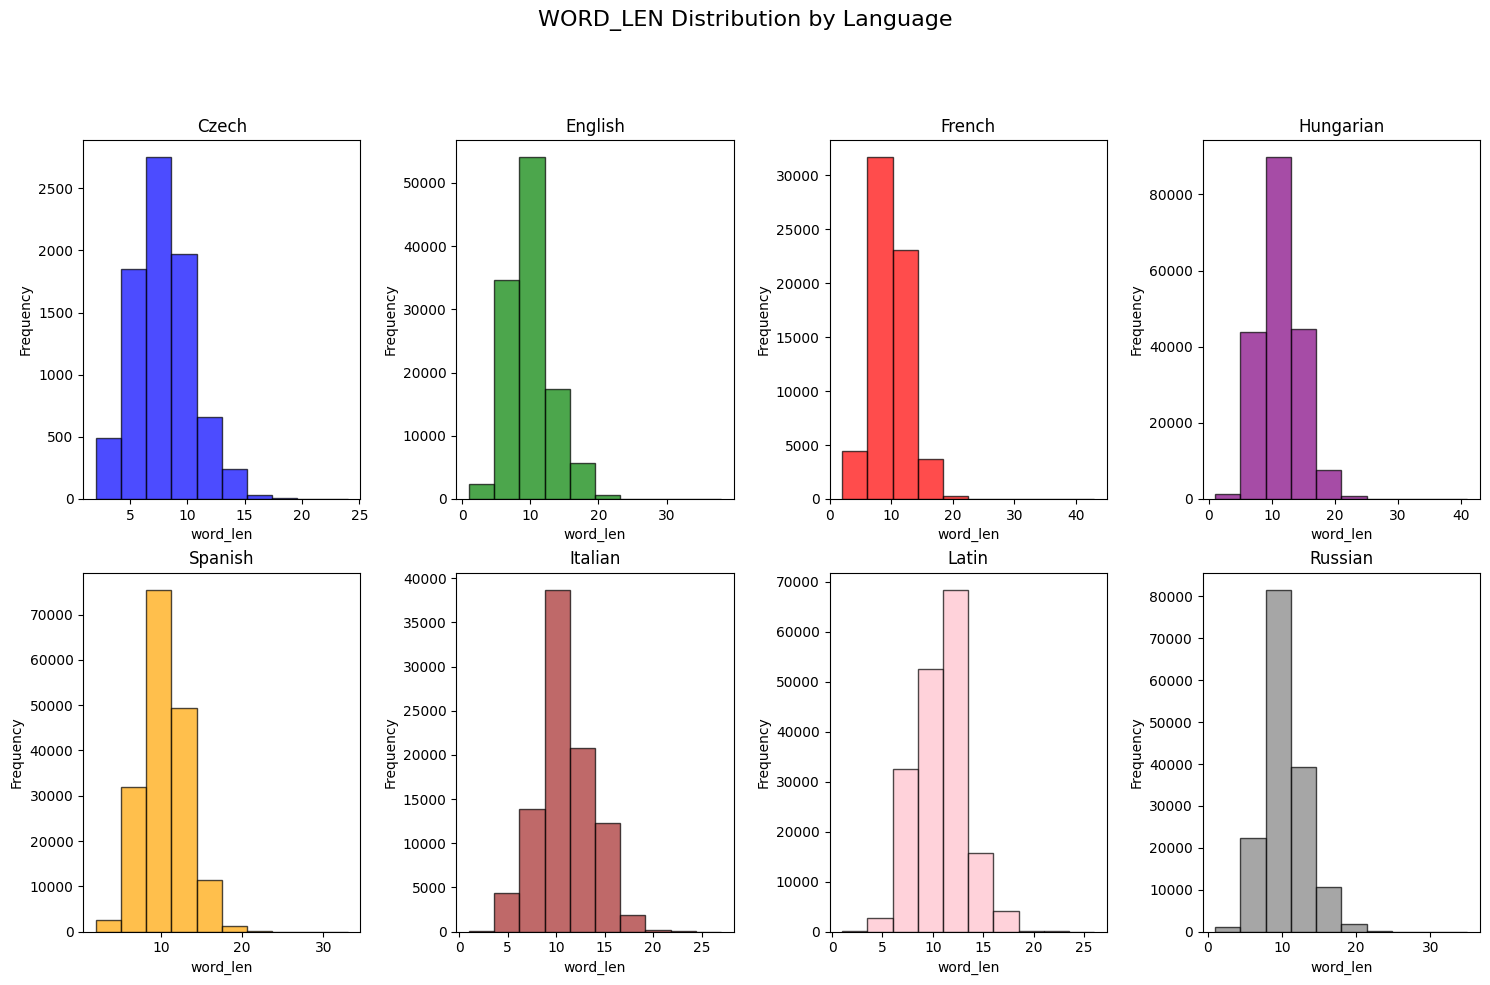

In [17]:
plot_multi_lang("word_len")

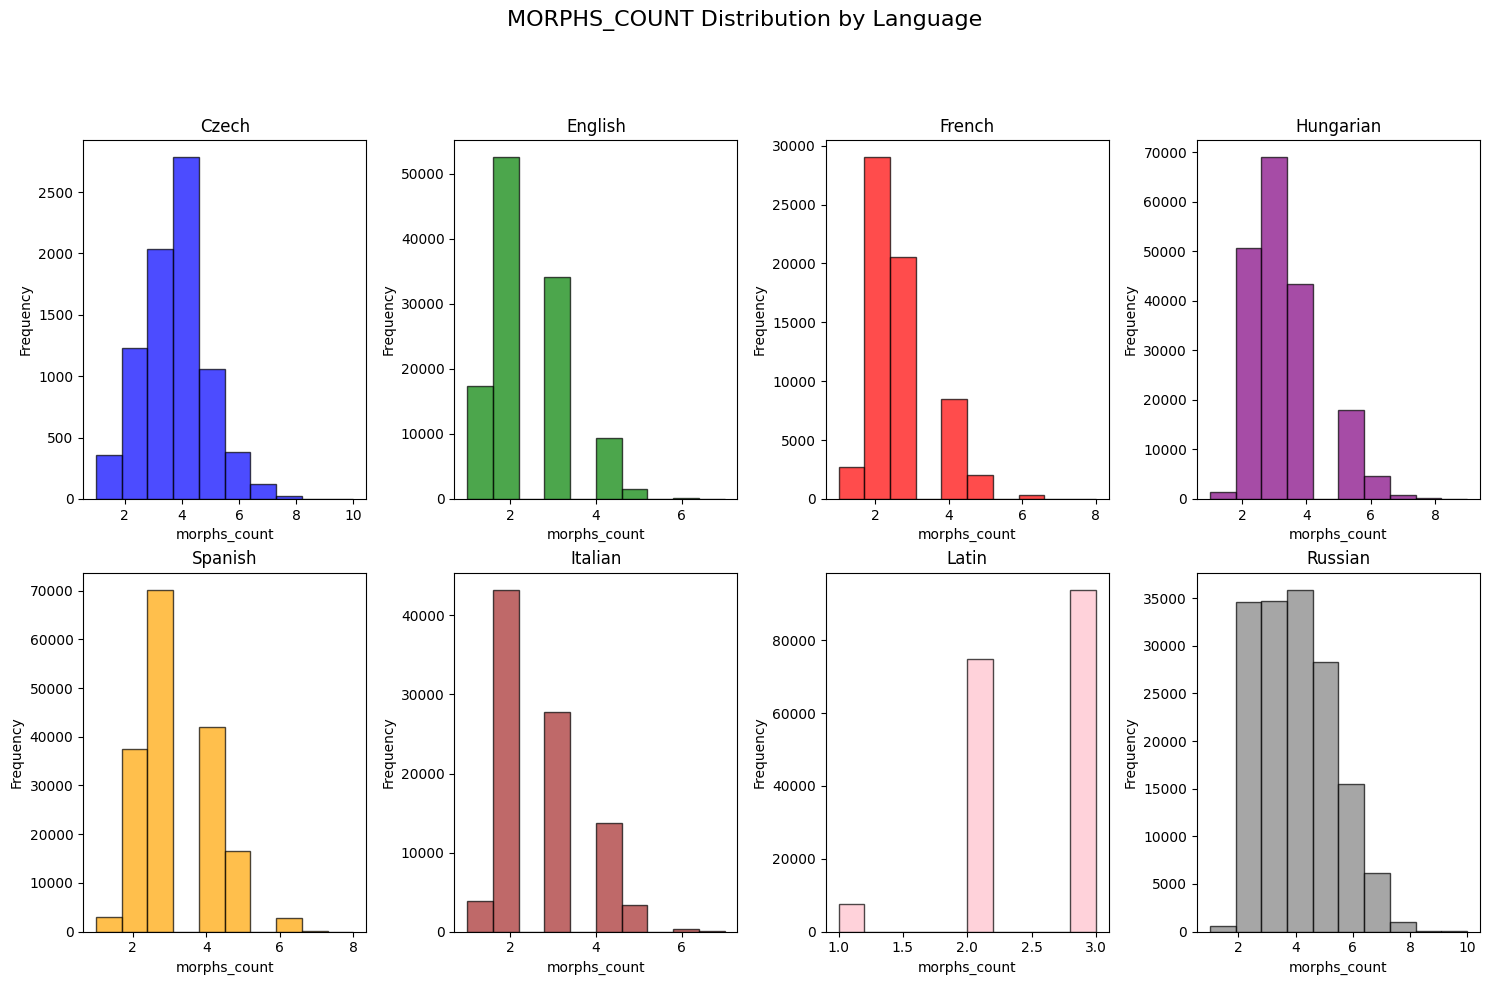

In [18]:
plot_multi_lang("morphs_count")



A partir de estas visualizaciones, podemos ofrecer comentarios sobre las disparidades en la morfología entre las diferentes lenguas. Por ejemplo, podemos examinar si ciertas lenguas tienden a tener palabras de longitud promedio más extensa, lo que posiblemente indique una morfología más intrincada o una estructura de palabra más elaborada. Asimismo, podemos contrastar la variabilidad en el número de morfemas por palabra entre las distintas lenguas para obtener percepciones sobre la complejidad morfológica relativa de cada una.